## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch with CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install additional dependencies
# !pip install matplotlib pandas pillow torcheval tqdm

# # Install extra dependencies for pandas
# !pip install tabulate pyarrow fastparquet

# # Install package for creating visually distinct colormaps
# !pip install distinctipy

# # Install utility packages
# !pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.datapoints import BoundingBox, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Setting Up the Project

### Setting a Random Number Seed

In [3]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

### Setting the Device and Data Type

In [4]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

### Setting the Directory Paths

In [5]:
# The name for the project
project_name = f"pytorch-mask-r-cnn-instance-segmentation"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# Define path to store datasets
# dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
dataset_dir = Path("./Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

pd.Series({
    "Project Directory:": project_dir, 
    "Dataset Directory:": dataset_dir
}).to_frame().style.hide(axis='columns')

Project Directory:,pytorch-mask-r-cnn-instance-segmentation
Dataset Directory:,Datasets


## Loading and Exploring the Dataset

### Setting the Dataset Path

In [6]:
# Set the name of the dataset
dataset_name = 'pytorch-for-information-extraction'

# 
gh_repo = f'MbassiJaphet/{dataset_name}'

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}/code/datasets/detection/student-id/')

pd.Series({
    "GitHub Repository:": gh_repo, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

GitHub Repository:,MbassiJaphet/pytorch-for-information-extraction
Dataset Path:,Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id


### Downloading the Dataset

In [7]:
# Clone the dataset repository from GitHub
!git clone {f'https://github.com/{gh_repo}.git'} {dataset_dir/dataset_name}

Cloning into 'Datasets/pytorch-for-information-extraction'...
remote: Enumerating objects: 1170, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1170 (delta 6), reused 5 (delta 5), pack-reused 1150
Receiving objects: 100% (1170/1170), 39.14 MiB | 31.29 MiB/s, done.
Resolving deltas: 100% (556/556), done.


### Getting the Image and Annotation Folders

In [8]:
# Get a list of image files in the dataset
img_file_paths = get_img_files(dataset_path)

# Get a list of JSON files in the dataset
annotation_file_paths = list(dataset_path.glob('*.json'))

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image File": [file.name for file in img_file_paths], 
              "Annotation File":[file.name for file in annotation_file_paths]}).head()

,Image File,Annotation File
0,10134.jpg,10134.json
1,10135.jpg,10135.json
2,10136.jpg,10136.json
3,10137.jpg,10137.json
4,10138.jpg,10138.json


### Get Image File Paths

In [9]:
# Create a dictionary that maps file names to file paths
img_dict = {
    file.stem : file 
    for file in img_file_paths
}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 150


,0
10134,Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10134.jpg
10135,Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10135.jpg
10136,Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10136.jpg
10137,Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10137.jpg
10138,Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10138.jpg


### Get Bounding Box Annotations

In [10]:
# Set the file path for the annotations DataFrame
annotation_df_pq_path = dataset_path/'annotations_df.parquet'

if annotation_df_pq_path.is_file():
    # Load the annotations DataFrame if present
    annotation_df = pd.read_parquet(annotation_df_pq_path)
else:
    # Create a generator that yields Pandas DataFrames containing the data from each JSON file
    cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths))

    # Concatenate the DataFrames into a single DataFrame
    annotation_df = pd.concat(cls_dataframes, ignore_index=False)

    # Assign the image file name as the index for each row
    annotation_df['index'] = annotation_df.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
    annotation_df = annotation_df.set_index('index')

    # Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
    annotation_df = annotation_df.loc[list(img_dict.keys())]

    # Save the annotations DataFrame to disk
    # annotation_df.to_parquet(annotation_df_pq_path)

# Print the first 5 rows of the DataFrame
annotation_df.head()

  0%|          | 0/150 [00:00<?, ?it/s]

,version,flags,shapes,lineColor,fillColor,imagePath,imageData,imageHeight,imageWidth
index,,,,,,,,,
10134,3.21.1,{},"[{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[83.7142857142857, 133.57142857142856], [86.57142857142856, 123.57142857142856], [95.14285714285714, 117.14285714285714], [595.1428571428571, 125.71428571428571], [604.4285714285713, 127.85714285714285], [607.2857142857142, 138.57142857142856], [619.4285714285713, 443.57142857142856], [612.2857142857142, 449.2857142857142], [97.99999999999997, 469.2857142857142], [85.14285714285714, 465.71428571428567], [78.0, 457.1428571428571]], 'shape_type': 'polygon', 'flags': {}}]","[0, 255, 0, 128]","[255, 0, 0, 128]",10134.jpg,,480,640
10135,3.21.1,{},"[{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[125.85714285714283, 288.57142857142856], [391.57142857142856, 24.285714285714285], [459.4285714285714, 7.857142857142857], [612.2857142857142, 166.42857142857142], [612.2857142857142, 174.28571428571428], [334.4285714285714, 477.85714285714283], [321.57142857142856, 478.5714285714285], [127.99999999999997, 297.1428571428571]], 'shape_type': 'polygon', 'flags': {}}]","[0, 255, 0, 128]","[255, 0, 0, 128]",10135.jpg,,480,640
10136,3.21.1,{},"[{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[62.28571428571428, 44.285714285714285], [70.85714285714285, 39.99999999999999], [571.5714285714286, 81.42857142857142], [582.9999999999999, 90.71428571428571], [634.4285714285713, 374.99999999999994], [634.4285714285713, 389.2857142857142], [622.9999999999999, 394.2857142857142], [46.571428571428555, 427.1428571428571], [35.85714285714285, 424.99999999999994], [30.857142857142847, 414.99999999999994]], 'shape_type': 'polygon', 'flags': {}}]","[0, 255, 0, 128]","[255, 0, 0, 128]",10136.jpg,,480,640
10137,3.21.1,{},"[{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[81.57142857142856, 137.85714285714283], [84.42857142857142, 129.28571428571428], [273.71428571428567, 29.999999999999996], [284.4285714285714, 29.999999999999996], [549.4285714285713, 277.85714285714283], [550.8571428571428, 288.57142857142856], [362.2857142857142, 472.85714285714283], [354.4285714285714, 472.85714285714283], [345.1428571428571, 467.1428571428571]], 'shape_type': 'polygon', 'flags': {}}, {'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[324.4285714285714, 69.28571428571428], [340.1428571428571, 0.7142857142857141], [525.8571428571428, 27.857142857142854], [529.4285714285713, 177.14285714285714], [395.1428571428571, 135.0]], 'shape_type': 'polygon', 'flags': {}}]","[0, 255, 0, 128]","[255, 0, 0, 128]",10137.jpg,,480,640
10138,3.21.1,{},"[{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[202.28571428571425, 12.142857142857142], [208.71428571428567, 2.857142857142856], [434.4285714285714, 70.0], [411.57142857142856, 392.1428571428571], [407.2857142857142, 445.71428571428567], [402.99999999999994, 453.57142857142856], [392.2857142857142, 454.99999999999994], [165.85714285714283, 470.71428571428567], [155.85714285714283, 467.85714285714283], [152.28571428571428, 459.2857142857142]], 'shape_type': 'polygon', 'flags': {}}]","[0, 255, 0, 128]","[255, 0, 0, 128]",10138.jpg,,480,640


### Inspecting the Class Distribution

#### Get image classes

In [11]:
# Explode the 'shapes' column in the annotation_df dataframe
# Convert the resulting series to a dataframe and rename the 'shapes' column to 'shapes'
# Apply the pandas Series function to the 'shapes' column of the dataframe
shapes_df = annotation_df['shapes'].explode().to_frame().shapes.apply(pd.Series)

In [12]:
# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = shapes_df['label'].unique().tolist()
# class_names.sort()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,student_id


#### Visualize the class distribution

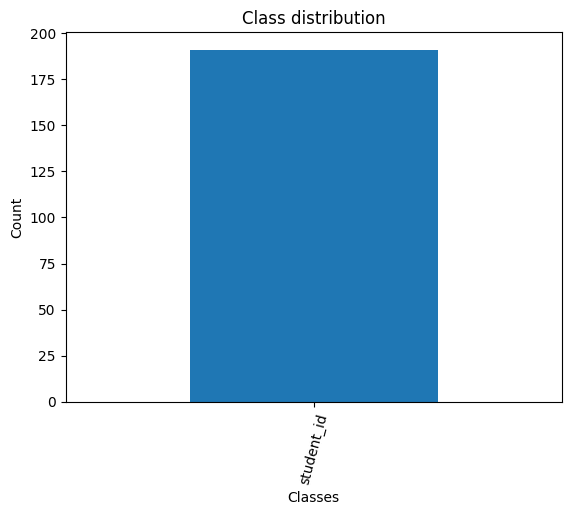

In [13]:
# Get the number of samples for each object class
class_counts = shapes_df['label'].value_counts()

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_names, rotation=75)  # Set the x-axis tick labels
plt.show()

In [14]:
class_names = ['background']+class_names

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,background
1,student_id


### Visualizing Bounding Box Annotations

#### Generate a color map

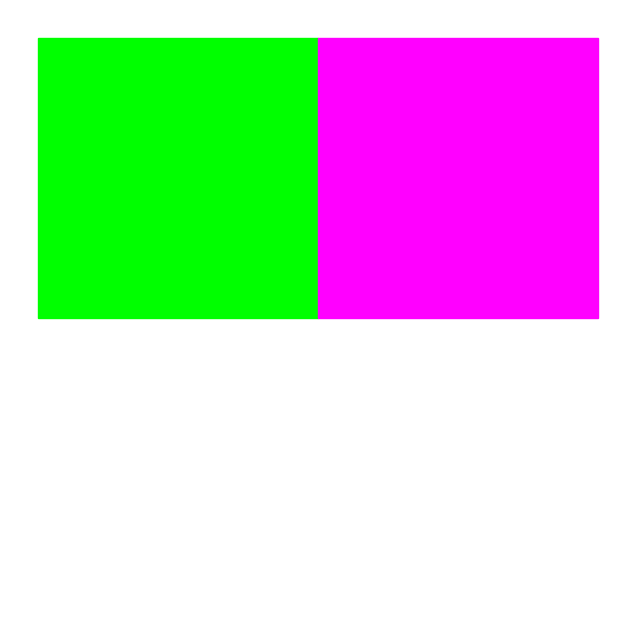

In [15]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [16]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [17]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (640, 480)


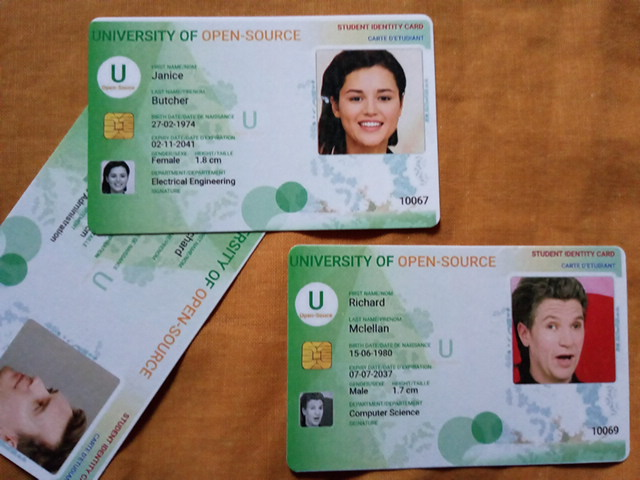

In [18]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[56]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [19]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,10067
version,3.21.1
flags,{}
shapes,"[{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[90.85714285714283, 22.142857142857142], [414.4285714285714, 17.857142857142854], [427.2857142857142, 19.285714285714285], [430.1428571428571, 24.999999999999996], [437.99999999999994, 222.85714285714283], [432.99999999999994, 227.1428571428571], [270.1428571428571, 231.42857142857142], [101.57142857142856, 234.28571428571428], [92.28571428571428, 232.85714285714283], [88.0, 227.85714285714283], [89.42857142857142, 44.99999999999999], [88.0, 31.428571428571427]], 'shape_type': 'polygon', 'flags': {}}, {'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[0.14285714285713802, 226.42857142857142], [85.85714285714283, 107.14285714285714], [87.28571428571428, 234.99999999999997], [101.57142857142856, 235.7142857142857], [266.57142857142856, 231.42857142857142], [91, 479], [38, 479], [0, 453]], 'shape_type': 'polygon', 'flags': {}}, {'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[287.99999999999994, 257.1428571428571], [293.71428571428567, 246.42857142857142], [314.4285714285714, 246.42857142857142], [615.1428571428571, 247.1428571428571], [621.5714285714286, 253.57142857142856], [626.5714285714286, 456.4285714285714], [617.9999999999999, 461.4285714285714], [311.57142857142856, 471.4285714285714], [297.2857142857143, 472.1428571428571], [290.1428571428571, 469.99999999999994], [285.1428571428571, 464.99999999999994]], 'shape_type': 'polygon', 'flags': {}}]"
lineColor,"[0, 255, 0, 128]"
fillColor,"[255, 0, 0, 128]"
imagePath,10067.jpg
imageData,
imageHeight,480
imageWidth,640


#### Annotate sample image

In [20]:
def get_mask_img(img_size, xy):
    mask_img = Image.new('L', img_size, 0)
    ImageDraw.Draw(mask_img, 'L').polygon(xy, fill=(255))
    return mask_img

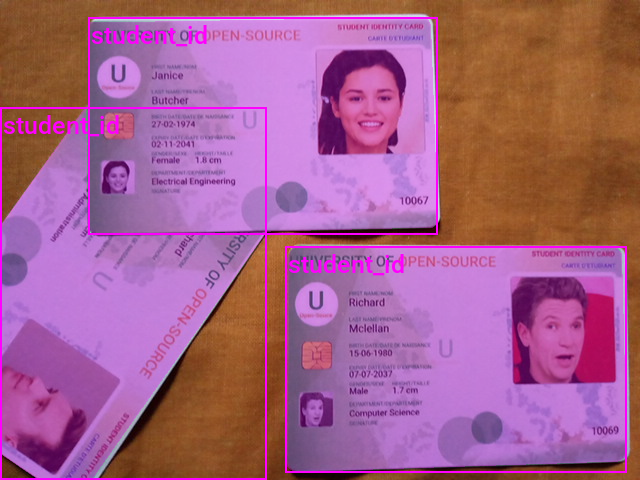

In [21]:
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]

shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
xy_coords = [[tuple(p) for p in points] for points in shape_points]
mask_imgs = [get_mask_img(sample_img.size, xy) for xy in xy_coords]
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])

bboxes = torchvision.ops.masks_to_boxes(masks)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img), 
    masks=masks, 
    alpha=0.3, colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=bboxes, 
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Selecting a Model

### Exploring Available Models

### Loading the YOLOX-Tiny Model

In [22]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [23]:
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT', 
                                 image_mean=[0.485, 0.456, 0.406], 
                                 image_std=[0.229, 0.224, 0.225]
                                ).to(device=device, dtype=dtype)

model_type = 'maskrcnn_resnet50_fpn_v2'

# Add attributes to store the device and model name for later reference
model.device = device
model.name = model_type

### Get Normalization Statistics

In [24]:
# Retrieve normalization statistics (mean and std) specific to the pretrained checkpoints
# norm_stats = [*NORM_STATS[model_type].values()] if pretrained else ([0.5]*3, [1.0]*3)
norm_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Print the mean and standard deviation
pd.DataFrame(norm_stats)

,0,1,2
0,0.485,0.456,0.406
1,0.229,0.224,0.225


### Summarizing the Model

In [25]:
test_inp = torch.randn(1, 3, 256, 256).to(device)

summary_df = markdown_to_pandas(f"{get_module_summary(model.eval(), [test_inp])}")

# # Filter the summary to only contain Conv2d layers and the model
# summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]
summary_df = summary_df[summary_df.index == 0]

summary_df.drop([
    'In size', 
    'Out size', 
    'Contains Uninitialized Parameters?'
], axis=1)

/home/innom-dt/mambaforge/envs/pytorch-env/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
/home/innom-dt/mambaforge/envs/pytorch-env/lib/python3.11/site-packages/torchtnt/utils/module_summary.py:271: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs
0,MaskRCNN,46.4 M,46.1 M,185 M,310 G


## Preparing the Data

### Training-Validation Split

In [26]:
# Get the list of image IDs
img_keys = list(img_dict.keys())

# Shuffle the image IDs
random.shuffle(img_keys)

# Define the percentage of the images that should be used for training
train_pct = 0.8
val_pct = 0.2

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_keys)*train_pct)
val_split = int(len(img_keys)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_keys = img_keys[:train_split]
val_keys = img_keys[train_split:]

# Print the number of images in the training and validation sets
pd.Series({
    "Training Samples:": len(train_keys),
    "Validation Samples:": len(val_keys)
}).to_frame().style.hide(axis='columns')

Training Samples:,120
Validation Samples:,30


### Data Augmentation

#### Set training image size

In [27]:
# Set training image size to a multiple of the max stride value
# train_sz = 384
train_sz = 512

#### Initialize the transforms

In [28]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

In [29]:
# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

#### Test the transforms

In [30]:
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]

shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
xy_coords = [[tuple(p) for p in points] for points in shape_points]
mask_imgs = [get_mask_img(sample_img.size, xy) for xy in xy_coords]
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])

bboxes = BoundingBox(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', spatial_size=sample_img.size[::-1])

In [31]:
class_to_idx = {c: i for i, c in enumerate(class_names)}
class_to_idx

{'background': 0, 'student_id': 1}

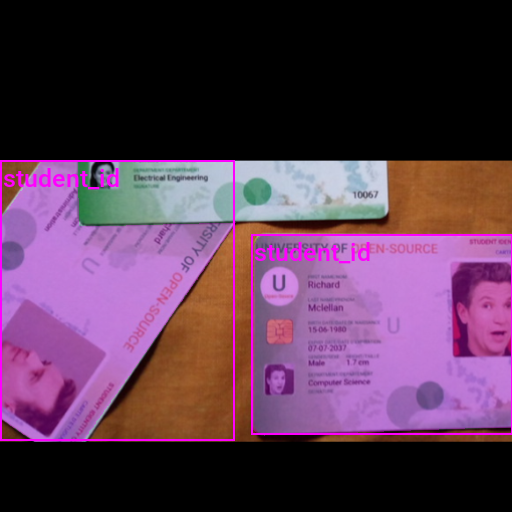

Source Image:,"(640, 480)"
Cropped Image:,"(580, 318)"
Resized Image:,"(510, 280)"
Padded Image:,"(510, 510)"
Resized Padded Image:,"(512, 512)"


In [32]:
# Prepare bounding box targets
targets = {
    'masks': Mask(masks), 
    'boxes': bboxes, 
    'labels': torch.Tensor([class_to_idx[label] for label in labels])
}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBox()(resized_padded_img, targets)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img), 
    masks=targets['masks'], 
    alpha=0.3, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=targets['boxes'], 
    labels=[class_names[int(label.item())] for label in targets['labels']], 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [33]:
class StudentIDDataset(Dataset):
    """
    This class represents a PyTorch Dataset for a collection of images and their annotations.
    The class is designed to load images along with their corresponding bounding box annotations and labels.
    """
    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Constructor for the HagridDataset class.

        Parameters:
        img_keys (list): List of unique identifiers for images.
        annotation_df (DataFrame): DataFrame containing the image annotations.
        img_dict (dict): Dictionary mapping image identifiers to image file paths.
        class_to_idx (dict): Dictionary mapping class labels to indices.
        transforms (callable, optional): Optional transform to be applied on a sample.
        """
        super(Dataset, self).__init__()
        
        self._img_keys = img_keys  # List of image keys
        self._annotation_df = annotation_df  # DataFrame containing annotations
        self._img_dict = img_dict  # Dictionary mapping image keys to image paths
        self._class_to_idx = class_to_idx  # Dictionary mapping class names to class indices
        self._transforms = transforms  # Image transforms to be applied
        
    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
        int: The number of items in the dataset.
        """
        return len(self._img_keys)
        
    def __getitem__(self, index):
        """
        Fetch an item from the dataset at the specified index.

        Parameters:
        index (int): Index of the item to fetch from the dataset.

        Returns:
        tuple: A tuple containing the image and its associated target (annotations).
        """
        # Retrieve the key for the image at the specified index
        img_key = self._img_keys[index]
        # Get the annotations for this image
        annotation = self._annotation_df.loc[img_key]
        # Load the image and its target (bounding boxes and labels)
        image, target = self._load_image_and_target(annotation)
        
        # Apply the transformations, if any
        if self._transforms:
            image, target = self._transforms(image, target)
        
        return image, target

    def _load_image_and_target(self, annotation):
        """
        Load an image and its target (bounding boxes and labels).

        Parameters:
        annotation (pandas.Series): The annotations for an image.

        Returns:
        tuple: A tuple containing the image and a dictionary with 'boxes' and 'labels' keys.
        """
        # Retrieve the file path of the image
        filepath = self._img_dict[annotation.name]
        # Open the image file and convert it to RGB
        image = Image.open(filepath).convert('RGB')
        # Calculate the bounding boxes in the image size scale
        # bbox_list = np.array([bbox*(image.size*2) for bbox in annotation.bboxes])
        
        # Convert bounding box coordinates from [xmin, ymin, width, height] to [xmin, ymin, xmax, ymax]
        # bbox_tensor = torchvision.ops.box_convert(torch.Tensor(bbox_list), 'xywh', 'xyxy')
        # Create a BoundingBox object with the bounding boxes
        # boxes = BoundingBox(bbox_tensor, format='xyxy', spatial_size=image.size[::-1])
        # Convert the class labels to indices
        # labels = torch.Tensor([self._class_to_idx[label] for label in annotation.labels])


        labels = [shape['label'] for shape in annotation['shapes']]
        labels = torch.Tensor([self._class_to_idx[label] for label in labels])
        labels = labels.to(dtype=torch.int64)

        shape_points = [shape['points'] for shape in annotation['shapes']]
        xy_coords = [[tuple(p) for p in points] for points in shape_points]
        mask_imgs = [get_mask_img(image.size, xy) for xy in xy_coords]
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs]))
        
        bboxes = BoundingBox(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', spatial_size=image.size[::-1])
                
        return image, {'masks': masks,'boxes': bboxes, 'labels': labels}

### Image Transforms

In [34]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImageTensor(), 
    transforms.ConvertImageDtype(),
    transforms.SanitizeBoundingBox(),
    # transforms.Normalize(*norm_stats),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

### Initialize Datasets

In [35]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the datasets using the defined transformations
train_dataset = StudentIDDataset(train_keys, annotation_df, img_dict, class_to_idx, train_tfms)
valid_dataset = StudentIDDataset(val_keys, annotation_df, img_dict, class_to_idx, valid_tfms)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

Training dataset size:,120
Validation dataset size:,30


### Inspect Samples

#### Inspect training set sample

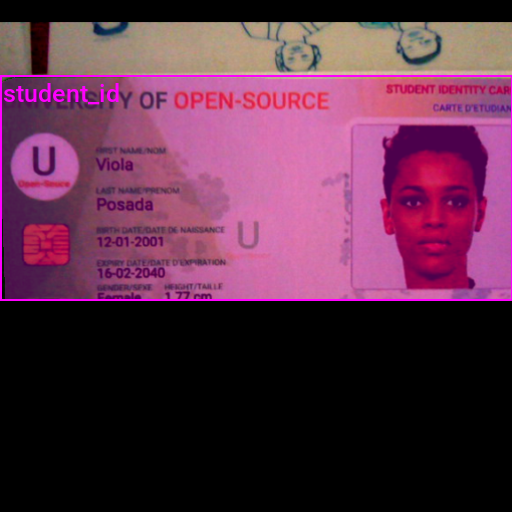

In [36]:
dataset_sample = train_dataset[0]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    # image=(denorm_img_tensor(dataset_sample[0], *norm_stats)*255).to(dtype=torch.uint8), 
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    masks=dataset_sample[1]['masks'], 
    alpha=0.3, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=[int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
)

tensor_to_pil(annotated_tensor)

#### Inspect validation set sample

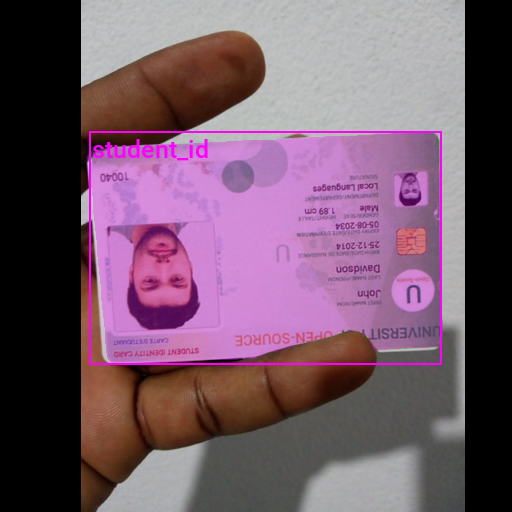

In [37]:
dataset_sample = valid_dataset[0]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    # image=(denorm_img_tensor(dataset_sample[0], *norm_stats)*255).to(dtype=torch.uint8), 
    image=(dataset_sample[0]*255).to(dtype=torch.uint8),
    masks=dataset_sample[1]['masks'], 
    alpha=0.3, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=[int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
)


tensor_to_pil(annotated_tensor)

### Initialize DataLoaders

In [38]:
# Set the training batch size
# bs = 8
bs = 4

# Set the number of worker processes for loading data.
num_workers = multiprocessing.cpu_count()//2
# num_workers = 1

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'collate_fn': lambda batch: tuple(zip(*batch)),
    'pin_memory': True,
    'pin_memory_device': device
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in validation DataLoader:': len(valid_dataloader)}
).to_frame().style.hide(axis='columns')

Number of batches in train DataLoader:,30
Number of batches in validation DataLoader:,8


In [39]:
def move_to_device(data, device):
    if isinstance(data, tuple):
        return tuple(move_to_device(d, device) for d in data)
    if isinstance(data, list):
        return list(move_to_device(d, device) for d in data)
    elif isinstance(data, dict):
        return {k: move_to_device(v, device) for k, v in data.items()}
    elif isinstance(data, torch.Tensor):
        return data.to(device)
    else:
        return data  # Non-tensor data types remain unchanged

## Fine-tuning the Model

### Define the Training Loop

In [40]:
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, is_training):
    """
    Function to run a single training or evaluation epoch.
    
    Args:
        model: A PyTorch model to train or evaluate.
        dataloader: A PyTorch DataLoader providing the data.
        optimizer: The optimizer to use for training the model.
        loss_func: The loss function used for training.
        device: The device (CPU or GPU) to run the model on.
        scaler: Gradient scaler for mixed-precision training.
        is_training: Boolean flag indicating whether the model is in training or evaluation mode.
    
    Returns:
        The average loss for the epoch.
    """
    # Set the model to training mode if is_training is True, otherwise set it to evaluation mode
    # model.train() if is_training else model.eval()
    model.train()
    
    epoch_loss = 0  # Initialize the total loss for this epoch
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")  # Initialize a progress bar
    
    # Loop over the data
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device
        inputs = torch.stack(inputs).to(device)
        # Extract the ground truth bounding boxes and labels
        # gt_bboxes, gt_labels = zip(*[(d['boxes'].to(device), d['labels'].to(device)) for d in targets])

        # Forward pass with Automatic Mixed Precision (AMP) context manager
        with autocast(torch.device(device).type):
            if is_training:
                losses = model(inputs.to(device), move_to_device(targets, device))
            else:
                with torch.no_grad():
                    losses = model(inputs.to(device), move_to_device(targets, device))
        
            # Compute the loss
            # losses = loss_func(cls_scores, bbox_preds, objectnesses, gt_bboxes, gt_labels)
            loss = sum([loss*2.0 for loss in losses.values()])  # Sum up the losses

        # If in training mode, backpropagate the error and update the weights
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                
            optimizer.zero_grad()

        # Update the total loss
        loss_item = loss.item()
        epoch_loss += loss_item
        
        # Update the progress bar
        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_id+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

        # If the loss is NaN or infinite, stop the training/evaluation process
        if math.isnan(loss_item) or math.isinf(loss_item):
            print(f"Loss is NaN or infinite at batch {batch_id}. Stopping {'training' if is_training else 'evaluation'}.")
            break

    # Cleanup and close the progress bar 
    progress_bar.close()
    
    # Return the average loss for this epoch
    return epoch_loss / (batch_id + 1)

def train_loop(model, 
               train_dataloader, 
               valid_dataloader, 
               optimizer,  
               lr_scheduler, 
               device, 
               epochs, 
               checkpoint_path, 
               use_scaler=False):
    """
    Main training loop.
    
    Args:
        model: A PyTorch model to train.
        train_dataloader: A PyTorch DataLoader providing the training data.
        valid_dataloader: A PyTorch DataLoader providing the validation data.
        optimizer: The optimizer to use for training the model.
        lr_scheduler: The learning rate scheduler.
        device: The device (CPU or GPU) to run the model on.
        epochs: The number of epochs to train for.
        checkpoint_path: The path where to save the best model checkpoint.
        use_scaler: Whether to scale graidents when using a CUDA device
    
    Returns:
        None
    """
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')  # Initialize the best validation loss

    # Loop over the epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run a training epoch and get the training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, is_training=True)
        # Run an evaluation epoch and get the validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, is_training=False)

        # If the validation loss is lower than the best validation loss seen so far, save the model checkpoint
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

            # Save metadata about the training process
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss, 
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

        # If the training or validation loss is NaN or infinite, stop the training process
        if any(math.isnan(loss) or math.isinf(loss) for loss in [train_loss, valid_loss]):
            print(f"Loss is NaN or infinite at epoch {epoch}. Stopping training.")
            break

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

### Set the Model Checkpoint Path

In [41]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

pytorch-mask-r-cnn-instance-segmentation/2023-09-18_18-15-25/maskrcnn_resnet50_fpn_v2.pth


### Save the Normalization Stats

In [42]:
# Convert tuples to dictionaries for easier JSON representation
norm_stats_dict = {"mean": norm_stats[0], "std_dev": norm_stats[1]}

# Export to JSON
with open(f"{checkpoint_dir}/norm_stats.json", "w") as f:
    json.dump(norm_stats_dict, f)

# Print the name of the file that the normalization stats were written to
print(f"{checkpoint_dir}/norm_stats.json")

pytorch-mask-r-cnn-instance-segmentation/2023-09-18_18-15-25/norm_stats.json


### Save the Color Map

In [43]:
# Create a color map and write it to a JSON file
color_map = {'items': [{'label': label, 'color': color} for label, color in zip(class_names, colors)]}
with open(f"{checkpoint_dir}/{dataset_path.name}-colormap.json", "w") as file:
    json.dump(color_map, file)

# Print the name of the file that the color map was written to
print(f"{checkpoint_dir}/{dataset_path.name}-colormap.json")

pytorch-mask-r-cnn-instance-segmentation/2023-09-18_18-15-25/student-id-colormap.json


### Configure the Training Parameters

In [44]:
# Learning rate for the model
lr = 5e-4

# Number of training epochs
epochs = 40
# epochs = 60

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=lr, 
                                                   total_steps=epochs*len(train_dataloader))

### Train the Model

In [45]:
train_loop(model=model, 
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer, 
           lr_scheduler=lr_scheduler, 
           device=torch.device(device), 
           epochs=epochs, 
           checkpoint_path=checkpoint_path,
           use_scaler=True)

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

## Making Predictions with the Model

### Preparing Input Data

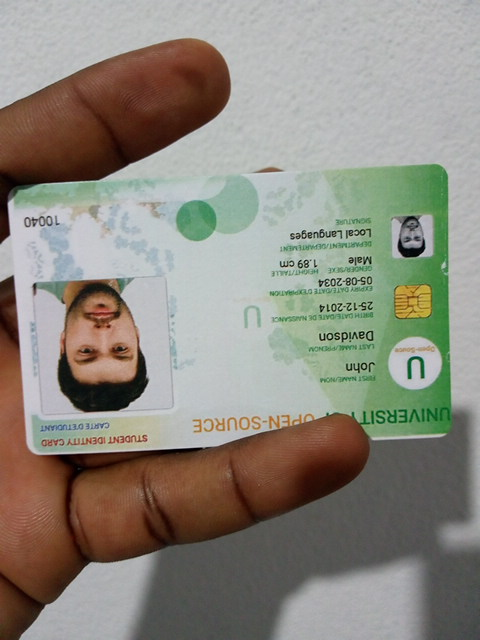

Source Image Size:,"(480, 640)"
Input Dims:,"(512, 682)"
Min Image Scale:,0.937500
Input Image Size:,"(512, 682)"


In [46]:
# Choose a random item from the validation set
file_id = random.choice(val_keys)

# Retrieve the image file path associated with the file ID
test_file = img_dict[file_id]

# Open the test file
test_img = Image.open(test_file).convert('RGB')

# Resize the test image
input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(input_img.size)

# Ensure the input dimensions are multiples of the max stride
input_dims = input_img.size

display(test_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_dims,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

#### Get the annotation data

In [47]:
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
xy_coords = [[tuple(p) for p in points] for points in shape_points]
mask_imgs = [get_mask_img(test_img.size, xy) for xy in xy_coords]
masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs]))

# Get the target labels and bounding boxes
target_labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
target_bboxes = BoundingBox(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', spatial_size=test_img.size[::-1])

#### Pass the input data to the model

In [48]:
# Set the model to evaluation mode
model.eval();

In [49]:
input_tensor = transforms.Compose([transforms.ToImageTensor(), 
                                   transforms.ConvertImageDtype(), 
                                   # transforms.Normalize(*norm_stats)
                                  ]
                                 )(input_img)[None].to(device)
model.to(device)
with torch.no_grad():
    model_output = model(input_tensor)

### Filtering Model Output

In [50]:
# Set the confidence threshold
threshold = 0.5

# Move model output to the CPU
model_output = move_to_device(model_output, 'cpu')

# Filter the output based on the confidence threshold
scores_mask = model_output[0]['scores'] > threshold

#### Annotate image using bounding box proposals

In [51]:
pred_bboxes = BoundingBox(model_output[0]['boxes'][scores_mask]*min_img_scale, format='xyxy', spatial_size=input_img.size[::-1])
pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]
pred_scores = model_output[0]['scores']
pred_masks = F.interpolate(model_output[0]['masks'][scores_mask], size=test_img.size[::-1])
pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])

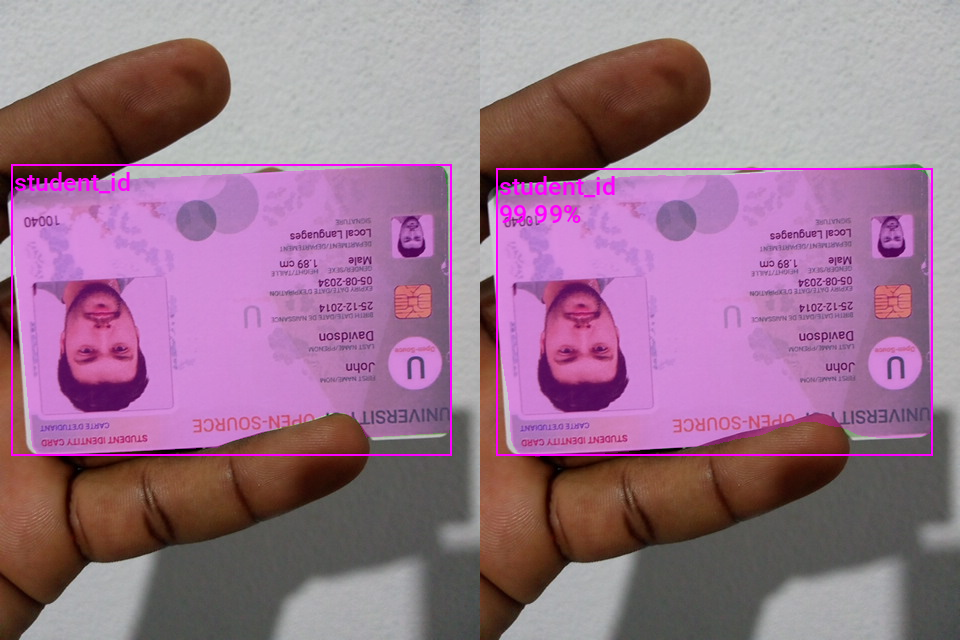

Target BBoxes:,['student_id:[ 11. 164. 451. 455.]']
Predicted BBoxes:,['student_id:[ 16.569 168.51 452.707 455.858]']
Confidence Scores:,['student_id: 99.99%']


In [52]:
target_colors=[int_colors[i] for i in [class_names.index(label) for label in target_labels]]
pred_colors=[int_colors[i] for i in [class_names.index(label) for label in pred_labels]]
img_tensor = transforms.PILToTensor()(test_img)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=masks, alpha=0.3, colors=target_colors)
# Create a tensor from the test image and annotate it
annotated_tensor = draw_bboxes(image=annotated_tensor, boxes=target_bboxes, labels=target_labels, colors=target_colors)
# Display the annotated test image
annotated_test_img = tensor_to_pil(annotated_tensor)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=pred_masks, alpha=0.3, colors=pred_colors)
# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=pred_bboxes, 
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)],
    colors=pred_colors
)

# Display the annotated test image with the predicted bounding boxes
display(stack_imgs([annotated_test_img, tensor_to_pil(annotated_tensor)]))

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Target BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(target_labels, np.round(target_bboxes.numpy(), decimals=3))],
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)]
}).to_frame().style.hide(axis='columns')